In [0]:
import requests
import pandas as pd

# Define project types
project_types = ['en.wikipedia.org', 'www.mediawiki.org', 'commons.wikimedia.org']

# Initialize an empty DataFrame to store the combined response data
combined_df = pd.DataFrame()

# Define the API URLs
pageviews_base_url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate"
edits_base_url = "https://wikimedia.org/api/rest_v1/metrics/edits/aggregate"
new_users_base_url = "https://wikimedia.org/api/rest_v1/metrics/registered-users/new"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36"
}

for project in project_types:
    # Fetch data from URLs
    pageviews_url=f"{pageviews_base_url}/{project}/all-access/all-agents/daily/2016010100/2022123100"
    edits_url = f"{edits_base_url}/{project}/all-editor-types/all-page-types/daily/20160101/20221231"
    new_users_url = f"{new_users_base_url}/{project}/daily/20160101/20221231"
     
    pageviews_data = requests.get(pageviews_url,headers=headers).json()["items"]
    #print(pageviews_data)
    edits_data = requests.get(edits_url,headers=headers).json()["items"][0]["results"]
    #print(edits_data)
    new_users_data = requests.get(new_users_url,headers=headers).json()["items"][0]["results"]
    #print(new_users_data)

    # Create DataFrames from the fetched data
    pageviews_df = pd.DataFrame(pageviews_data)
    edits_df = pd.DataFrame(edits_data)
    new_users_df = pd.DataFrame(new_users_data)

    # Convert timestamp to datetime format and set timezone
    pageviews_df["timestamp"] = pageviews_df["timestamp"].str[:8]  # Extract the first 8 characters as the date
    pageviews_df["timestamp"] = pd.to_datetime(pageviews_df["timestamp"], format="%Y%m%d")
    pageviews_df["timestamp"] = pageviews_df["timestamp"].dt.tz_localize(None)  # Remove timezone

    edits_df["timestamp"] = pd.to_datetime(edits_df["timestamp"])
    edits_df["timestamp"] = edits_df["timestamp"].dt.tz_localize(None)  # Remove timezone
    
    new_users_df["timestamp"] = pd.to_datetime(new_users_df["timestamp"])
    new_users_df["timestamp"] = new_users_df["timestamp"].dt.tz_localize(None)  # Remove timezone

    # Merge DataFrames based on timestamp with left join
    project_combined_df = pd.merge(pageviews_df, edits_df, on="timestamp", how="left")
    project_combined_df = pd.merge(project_combined_df, new_users_df, on="timestamp", how="left")

    # Fill missing values if needed
    project_combined_df.fillna(0, inplace=True)
    
    # Add the current project's data to the combined DataFrame
    combined_df = pd.concat([combined_df, project_combined_df], ignore_index=True)

# Display the cleaned combined DataFrame
print("Cleaned DataFrame:")
print(combined_df.head())

Cleaned DataFrame:
        project      access       agent granularity  timestamp      views  \
0  en.wikipedia  all-access  all-agents       daily 2016-01-01  269391451   
1  en.wikipedia  all-access  all-agents       daily 2016-01-02  292923392   
2  en.wikipedia  all-access  all-agents       daily 2016-01-03  299498830   
3  en.wikipedia  all-access  all-agents       daily 2016-01-04  305898529   
4  en.wikipedia  all-access  all-agents       daily 2016-01-05  300297408   

      edits  new_registered_users  
0  125561.0                4367.0  
1  139675.0                5289.0  
2  135630.0                5359.0  
3  153188.0                5904.0  
4  147655.0                5935.0  


In [0]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7671 entries, 0 to 7670
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   project               7671 non-null   object        
 1   access                7671 non-null   object        
 2   agent                 7671 non-null   object        
 3   granularity           7671 non-null   object        
 4   timestamp             7671 non-null   datetime64[ns]
 5   views                 7671 non-null   int64         
 6   edits                 7671 non-null   float64       
 7   new_registered_users  7671 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 479.6+ KB


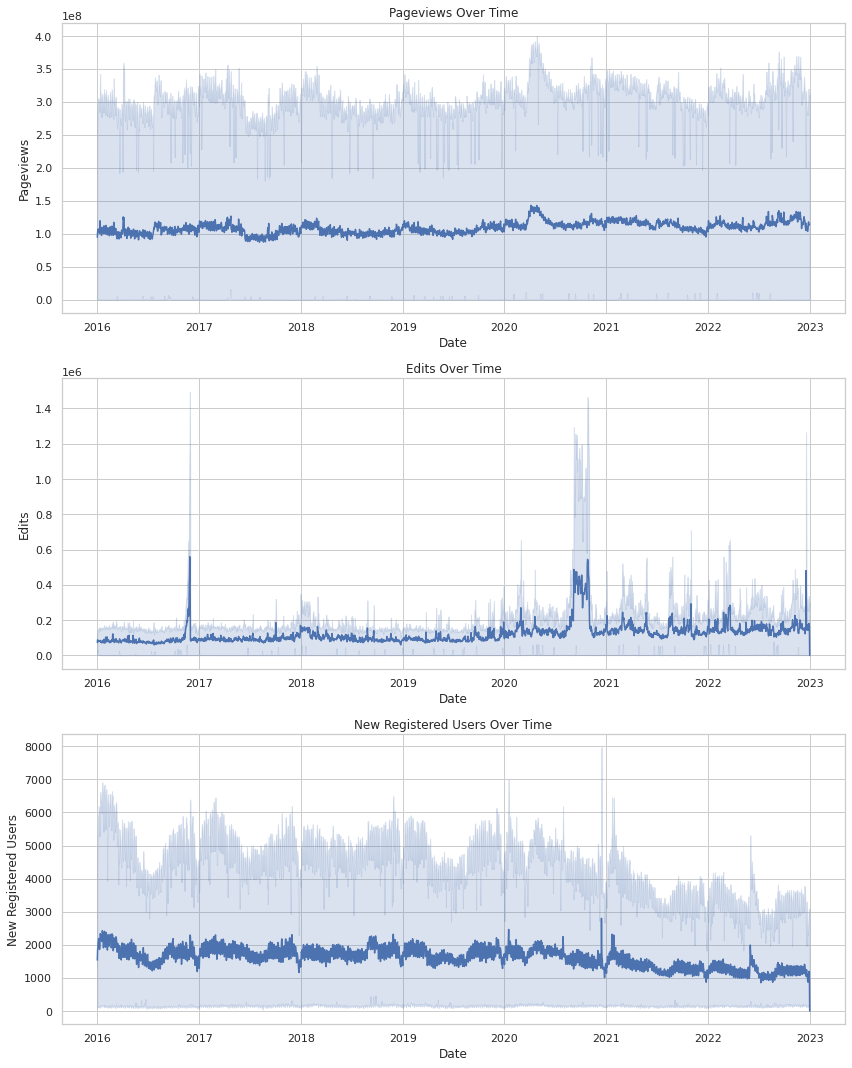

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plots
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

# Plot pageviews
sns.lineplot(data=combined_df, x="timestamp", y="views", ax=axes[0])
axes[0].set_title("Pageviews Over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Pageviews")

# Plot edits
sns.lineplot(data=combined_df, x="timestamp", y="edits", ax=axes[1])
axes[1].set_title("Edits Over Time")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Edits")

# Plot new registered users
sns.lineplot(data=combined_df, x="timestamp", y="new_registered_users", ax=axes[2])
axes[2].set_title("New Registered Users Over Time")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("New Registered Users")

# Adjust the layout
plt.tight_layout()
plt.show()


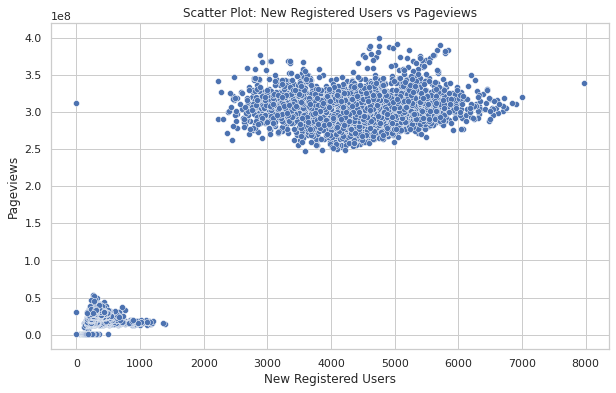

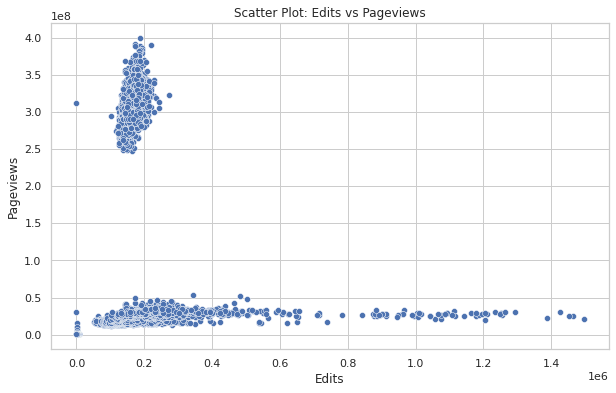

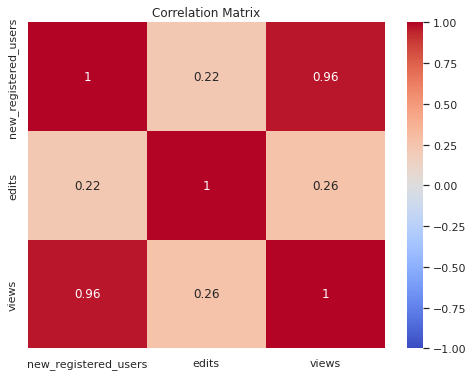

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plots
sns.set(style="whitegrid")

# Create scatter plot of new_registered_users vs pageviews
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x="new_registered_users", y="views")
plt.title("Scatter Plot: New Registered Users vs Pageviews")
plt.xlabel("New Registered Users")
plt.ylabel("Pageviews")
plt.show()

# Create scatter plot of edits vs pageviews
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x="edits", y="views")
plt.title("Scatter Plot: Edits vs Pageviews")
plt.xlabel("Edits")
plt.ylabel("Pageviews")
plt.show()

# Create a correlation matrix
correlation_matrix = combined_df[["new_registered_users", "edits", "views"]].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data=correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Selecting the predictor (X) and target (y) variables
X = combined_df[['new_registered_users']]
y = combined_df['views']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model using MAE and R-squared
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')
print('Model Coefficients:', model.coef_)
print('Model Intercept:', model.intercept_)


Mean Absolute Error (MAE): 23698264.58755434
R-squared (R2): 0.9309452953523769
Model Coefficients: [65816.38050187]
Model Intercept: 1496919.751275614
